In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os.path as op
import xarray as xr

In [20]:
dir = '/home/INT/brovelli.a/code/acrho/data/spiking_model/project/netw/homog'
fname = op.join(dir, 'data.pkl')
df = pd.read_pickle(fname)

In [126]:
fr = []
for t in range(len(df)):

    # Spike matrix sparse 100 neurons x 10001 time points
    spike_matrix = np.zeros((100, int(1e4)+1))

    # Excitatory neurons
    time_raster_exc = df.at[t, 't_spike_exc']
    # Sample at msec resolution
    time_raster_exc = np.round(time_raster_exc, 3) * 1000
    # Make it an index
    ind_time = time_raster_exc.astype(int)
    ind_neuron = df.at[t, 'index_spike_exc']
    # Make a sparse matrix
    spike_matrix[ind_neuron, ind_time] = 1

    # Inhibitory neurons
    time_raster_inh = df.at[t, 't_spike_inh']
    # Sample at msec resolution
    time_raster_inh = np.round(time_raster_inh, 3) * 1000
    # Make it an index
    ind_time = time_raster_inh.astype(int)
    ind_neuron = df.at[t, 'index_spike_inh']
    # Make a sparse matrix and append to spike_matrix
    spike_matrix[ind_neuron, ind_time] = 1

    # Convolving with a boxcar filter
    from scipy.ndimage import convolve1d
    sigma = 10
    fr_trial = convolve1d(spike_matrix, np.ones(sigma), axis=1)

    # Binarise firing rate and fill with 0s and 1s
    fr_trial[fr_trial > 0] = 1

    # from scipy.ndimage import gaussian_filter1d
    # sigma = 30
    # fr_trial = gaussian_filter1d(spike_matrix, sigma, axis=1)

    # Append fr_trial to fr
    fr.append(fr_trial)

# make it DataArray
fr = xr.DataArray(fr, dims=['trials', 'neurons', 'times'])
# add attributes and coordinates
fr.attrs['units'] = 'probability'
fr.attrs['description'] = 'Firing probability'
fr.coords['trials'] = np.arange(200)
fr.coords['neurons'] = np.arange(100)
fr.coords['times'] = np.arange(10001)



In [28]:
# Compute single-trial firing rate
for n in range(len(df)):

    time_raster_exc = df.at[n, 't_spike_exc']
    exc_spike= df.at[n, 'index_spike_exc']


    time_raster_inh= df.at[n, 't_spike_inh']
    inh_spike= df.at[n, 'index_spike_inh']



In [30]:
# Create a 2D matrix binary matrix with 1 when a spike occurs
exc_raster = np.zeros((len(exc_spike), len(time_raster_exc)))
for i in range(len(exc_spike)):
    exc_raster[i, exc_spike[i]] = 1

inh_raster = np.zeros((len(inh_spike), len(time_raster_inh)))
for i in range(len(inh_spike)):
    inh_raster[i, inh_spike[i]] = 1

exc_firing_rate = np.sum(exc_raster, axis=0)/len(exc_spike)
inh_firing_rate = np.sum(inh_raster, axis=0)/len(inh_spike)

df.at[n, 'exc_firing_rate'] = exc_firing_rate
df.at[n, 'inh_firing_rate'] = inh_firing_rate


ValueError: setting an array element with a sequence.

In [4]:
time_raster_exc = df.at[100, 't_spike_exc']
exc_spike= df.at[100, 'index_spike_exc']
time_raster_inh= df.at[100, 't_spike_inh']
inh_spike= df.at[100, 'index_spike_inh']

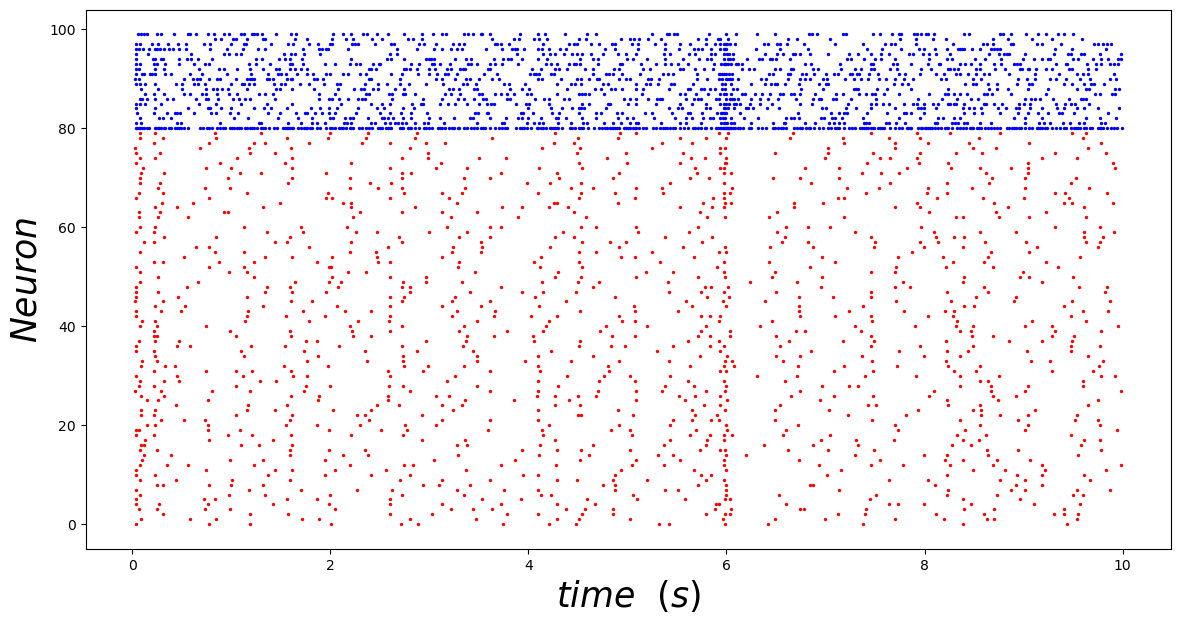

In [7]:
FIG=  []
fig=plt.figure(figsize=(14,7))
plt.scatter(time_raster_exc,exc_spike, s=2,color='red')
plt.scatter(time_raster_inh,inh_spike, s=2,color='blue')


plt.xlabel(r"$time \ \ (s) $",fontsize=25)
plt.ylabel(r"$Neuron \ \ $",fontsize=25)
plt.show()